In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_test.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 39, 40):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+39, 'gx'].values
    gy_values = train_df.loc[i:i+39, 'gy'].values
    gz_values = train_df.loc[i:i+39, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+39, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append([gx_values, gy_values, gz_values])

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 39, 40):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+39, 'gx'].values
    gy_values = test_df.loc[i:i+39, 'gy'].values
    gz_values = test_df.loc[i:i+39, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+39, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append([gx_values, gy_values, gz_values])

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
y_test = onehot_encoder.transform(integer_encoded_test)

# LSTM 모델 정의
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(3, 40)))  # 3개의 시퀀스, 각 시퀀스에 40개의 피처
model.add(keras.layers.Dense(5, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = history.model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_lstm.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_lstm.npy', label_encoder.classes_)

# 가중치를 로드하기 위해 모델 구성
loaded_model = keras.models.Sequential()
loaded_model.add(keras.layers.LSTM(128, input_shape=(3, 40)))  # 3개의 시퀀스, 각 시퀀스에 40개의 피처
loaded_model.add(keras.layers.Dense(5, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 피클 파일에서 가중치 로드
loaded_model_weights = pickle.load(open('../model/best_model_weights_lstm.pkl', 'rb'))

# 모델에 로드된 가중치 설정
loaded_model.set_weights(loaded_model_weights)

# 모델 컴파일
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 저장
loaded_model.save('../model/loaded_model_lstm.h5')

Epoch 1/10
174/174 [==============================] - 2s 5ms/step - loss: 1.0991 - accuracy: 0.5882 - val_loss: 0.8333 - val_accuracy: 0.6988
Epoch 2/10
174/174 [==============================] - 0s 2ms/step - loss: 0.6242 - accuracy: 0.7806 - val_loss: 0.6666 - val_accuracy: 0.7547
Epoch 3/10
174/174 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.8336 - val_loss: 0.6055 - val_accuracy: 0.7680
Epoch 4/10
174/174 [==============================] - 0s 2ms/step - loss: 0.3590 - accuracy: 0.8765 - val_loss: 0.5616 - val_accuracy: 0.7841
Epoch 5/10
174/174 [==============================] - 0s 2ms/step - loss: 0.2871 - accuracy: 0.9116 - val_loss: 0.5376 - val_accuracy: 0.7980
Epoch 6/10
174/174 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 0.9351 - val_loss: 0.5191 - val_accuracy: 0.8092
Epoch 7/10
174/174 [==============================] - 0s 2ms/step - loss: 0.1750 - accuracy: 0.9540 - val_loss: 0.5003 - val_accuracy: 0.8148
Epoch 

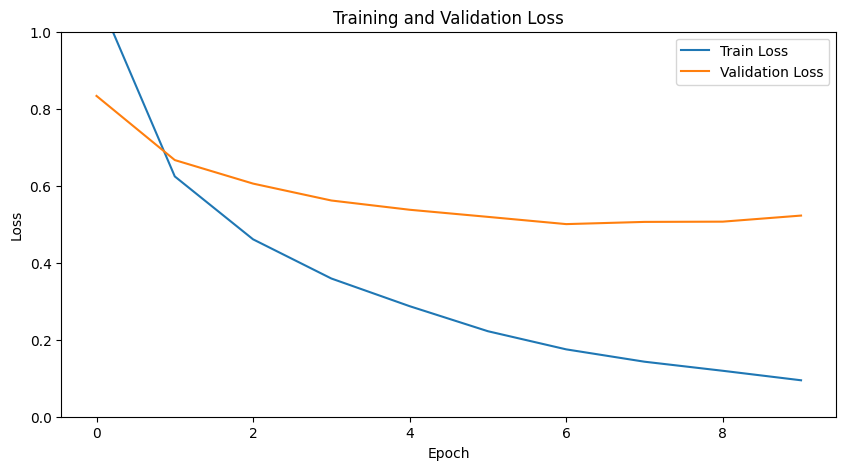

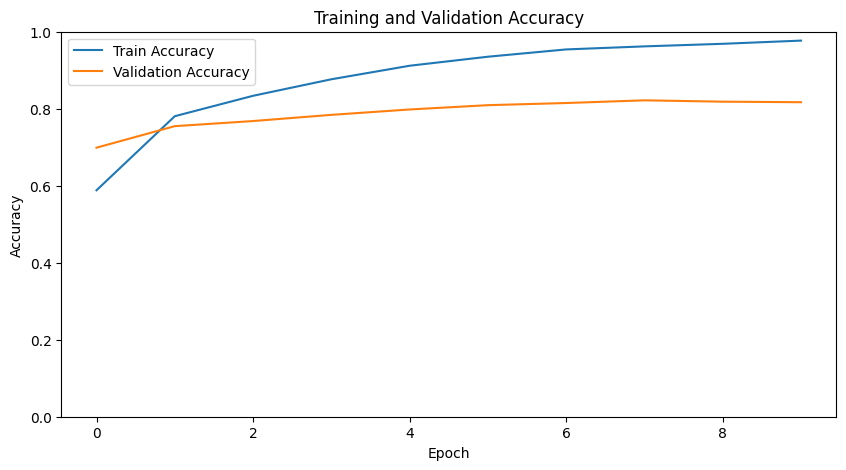

In [6]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()